In [1]:
!pip install opencv-python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import cv2
import segmentation_models as sm
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split

from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

2023-12-05 17:15:44.178220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 17:15:44.692180: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 17:15:44.819615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valerio/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/../../lib64:


Segmentation Models: using `keras` framework.


In [2]:
images = "/home/valerio/code/ValerioCann/ai4mars-dataset-merged-0.1/msl/images"
tr_lab = "/home/valerio/code/ValerioCann/ai4mars-dataset-merged-0.1/msl/labels/train"
edr = images + "/edr"
mxy = images + "/mxy" # not required
rng = images + "/rng-30m" # not required

In [4]:
edr_files = os.listdir(edr)
trlab_files = os.listdir(tr_lab)

X = []
y = []
c = 0

# preparing X and y
for lab_name in trlab_files:
    img_name = lab_name[:-4] + ".JPG"
    
    if img_name in edr_files:
        
        img_path = os.path.join(edr, img_name)
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr, dsize = (224, 224))
        
       
        lab_path = os.path.join(tr_lab, lab_name)
        lab_arr = cv2.imread(lab_path, 0)
        lab_arr = cv2.resize(lab_arr, (224, 224), interpolation = cv2.INTER_NEAREST)
        
        X.append(img_arr)
        y.append(lab_arr)
        
    c += 1
    if c >= 1000:
        break
        
X = np.asarray(X, dtype = np.float32) / 255.0
y = np.array(y, dtype = np.uint8)


# 0 - soil
# 1 - bedrock
# 2 - sand
# 3 - big rock
# 255 -> 4 - NULL (no label)


# keeping integer values in labels will help us in segmentation task (UNet)
y[y==255] = 4

print(X.shape, y.shape)

(482, 224, 224, 3) (482, 224, 224)


##### RGB key:
- 0,0,0 - soil
- 1,1,1 - bedrock
- 2,2,2 - sand
- 3,3,3 - big rock
- 255,255,255 - NULL (no label)

In [5]:
X[1].shape

(224, 224, 3)

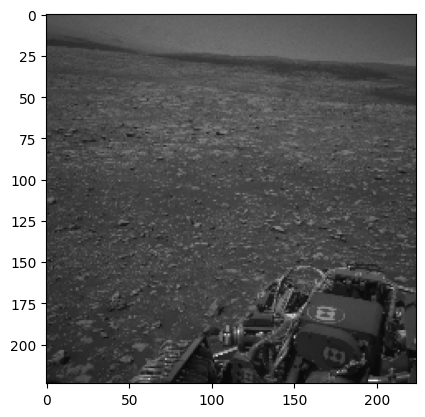

In [6]:
plt.imshow(X[1])

[0 4]


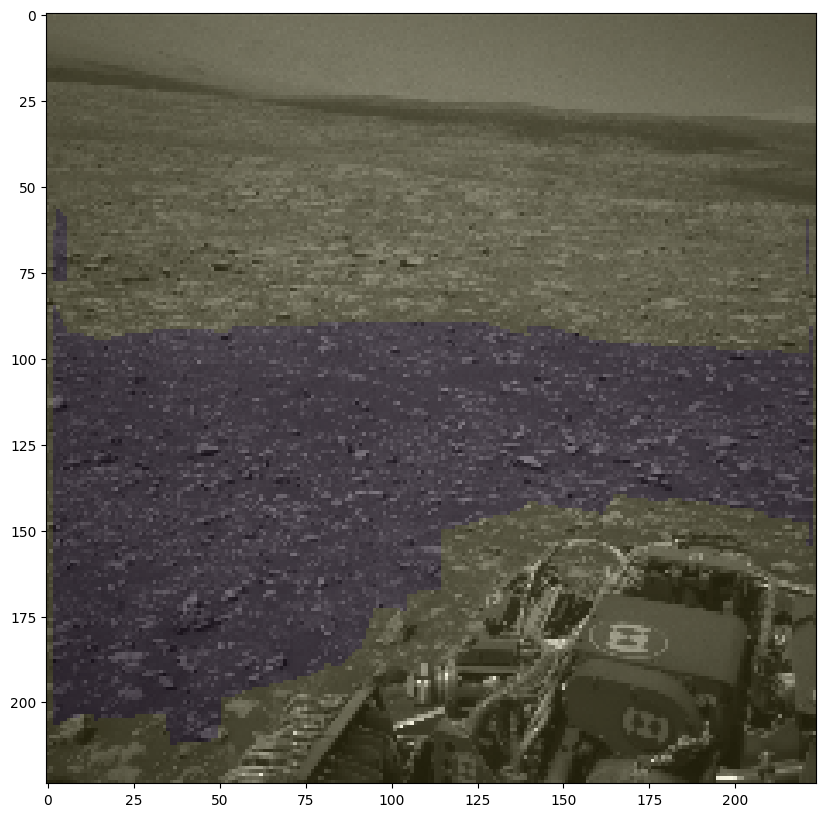

In [7]:
print(np.unique(y[1]))

plt.figure(figsize = (10, 10))

plt.imshow(X[1])
plt.imshow(y[1], alpha = 0.1)

plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 42)

In [14]:
X_train.shape, y_train.shape

((337, 224, 224, 3), (337, 224, 224))

In [9]:
# Charger le modèle UNet avec l'encodeur ResNet50 pré-entraîné et des poids ImageNet
model = sm.Unet('resnet50', encoder_weights='imagenet', classes=5, activation='softmax')

2023-12-05 17:17:22.931710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valerio/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/../../lib64:
2023-12-05 17:17:22.933415: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-05 17:17:22.935208: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (asus): /proc/driver/nvidia/version does not exist
2023-12-05 17:17:22.942497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate 

In [10]:
model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

                                                                                                  
 stage1_unit2_bn3 (BatchNormali  (None, None, None,   256        ['stage1_unit2_conv2[0][0]']     
 zation)                        64)                                                               
                                                                                                  
 stage1_unit2_relu3 (Activation  (None, None, None,   0          ['stage1_unit2_bn3[0][0]']       
 )                              64)                                                               
                                                                                                  
 stage1_unit2_conv3 (Conv2D)    (None, None, None,   16384       ['stage1_unit2_relu3[0][0]']     
                                256)                                                              
                                                                                                  
 add_1 (Ad

 zation)                        512)                                                              
                                                                                                  
 stage2_unit2_relu1 (Activation  (None, None, None,   0          ['stage2_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 stage2_unit2_conv1 (Conv2D)    (None, None, None,   65536       ['stage2_unit2_relu1[0][0]']     
                                128)                                                              
                                                                                                  
 stage2_unit2_bn2 (BatchNormali  (None, None, None,   512        ['stage2_unit2_conv1[0][0]']     
 zation)                        128)                                                              
          

 stage2_unit4_conv2 (Conv2D)    (None, None, None,   147456      ['zero_padding2d_8[0][0]']       
                                128)                                                              
                                                                                                  
 stage2_unit4_bn3 (BatchNormali  (None, None, None,   512        ['stage2_unit4_conv2[0][0]']     
 zation)                        128)                                                              
                                                                                                  
 stage2_unit4_relu3 (Activation  (None, None, None,   0          ['stage2_unit4_bn3[0][0]']       
 )                              128)                                                              
                                                                                                  
 stage2_unit4_conv3 (Conv2D)    (None, None, None,   65536       ['stage2_unit4_relu3[0][0]']     
          

                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, None, None,   4096       ['add_8[0][0]']                  
 zation)                        1024)                                                             
                                                                                                  
 stage3_unit3_relu1 (Activation  (None, None, None,   0          ['stage3_unit3_bn1[0][0]']       
 )                              1024)                                                             
                                                                                                  
 stage3_unit3_conv1 (Conv2D)    (None, None, None,   262144      ['stage3_unit3_relu1[0][0]']     
                                256)                                                              
                                                                                                  
 stage3_un

 2D)                            256)                                                              
                                                                                                  
 stage3_unit5_conv2 (Conv2D)    (None, None, None,   589824      ['zero_padding2d_13[0][0]']      
                                256)                                                              
                                                                                                  
 stage3_unit5_bn3 (BatchNormali  (None, None, None,   1024       ['stage3_unit5_conv2[0][0]']     
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu3 (Activation  (None, None, None,   0          ['stage3_unit5_bn3[0][0]']       
 )                              256)                                                              
          

 add_13 (Add)                   (None, None, None,   0           ['stage4_unit1_conv3[0][0]',     
                                2048)                             'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   8192       ['add_13[0][0]']                 
 zation)                        2048)                                                             
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              2048)                                                             
                                                                                                  
 stage4_unit2_conv1 (Conv2D)    (None, None, None,   1048576     ['stage4_unit2_relu1[0][0]']     
          

                                256)                                                              
                                                                                                  
 decoder_stage0a_bn (BatchNorma  (None, None, None,   1024       ['decoder_stage0a_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 decoder_stage0a_relu (Activati  (None, None, None,   0          ['decoder_stage0a_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage0b_conv (Conv2D)  (None, None, None,   589824      ['decoder_stage0a_relu[0][0]']   
                                256)                                                              
          

 decoder_stage3b_conv (Conv2D)  (None, None, None,   9216        ['decoder_stage3a_relu[0][0]']   
                                32)                                                               
                                                                                                  
 decoder_stage3b_bn (BatchNorma  (None, None, None,   128        ['decoder_stage3b_conv[0][0]']   
 lization)                      32)                                                               
                                                                                                  
 decoder_stage3b_relu (Activati  (None, None, None,   0          ['decoder_stage3b_bn[0][0]']     
 on)                            32)                                                               
                                                                                                  
 decoder_stage4_upsampling (UpS  (None, None, None,   0          ['decoder_stage3b_relu[0][0]']   
 ampling2D

In [13]:
es = callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(X_train, y_train,
          batch_size=16,
          epochs=3,
          validation_split=0.3,
          callbacks=[es],
          verbose=0)   

ValueError: in user code:

    File "/home/valerio/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/valerio/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/segmentation_models/base/objects.py", line 114, in __call__  *
        return self.l1(gt, pr) + self.l2(gt, pr)
    File "/home/valerio/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/segmentation_models/losses.py", line 130, in __call__  *
        return F.binary_crossentropy(gt, pr, **self.submodules)
    File "/home/valerio/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/segmentation_models/base/functional.py", line 256, in binary_crossentropy  *
        return backend.mean(backend.binary_crossentropy(gt, pr))
    File "/home/valerio/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 224, 224, 5) vs (None, 224, 224)).


In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
plot_history(history)

In [ ]:
model.evaluate(X_test, y_test)